In [1]:
import sys
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib.pyplot as plt
import numpy as np
import ot
import time
import numba
import numpy as np
print(os.getcwd())
os.chdir(os.getcwd())
from sopt.library import *
from sopt.lib_ot import * 



/home/baly/projects/sliced_opt


In [2]:
import pot1d

In [3]:
def Gaussian_mixture(mu_list, variance_list,n):
    N=mu_list.shape[0]
    indices=np.random.randint(0,N,n)
    X=np.zeros(n)
    for i in range(n):
        X[i]=np.random.normal(mu_list[indices[i]],variance_list[i])
    return X

print('start3')
    

start3


In [ ]:

#Lambda=60
Lambda_list=np.array([20.0,100.0]).astype(np.float32)
time_lp_list=[[],[]]
time_new_list=[[],[]]
time_new_C_list=[[],[]]

device='cpu'
step=500
k=1
print('start')
n_list=[int(1e2),int(1e3),int(1e4),5*int(1e4),int(1e5)]
for n in n_list:
    m=n #+1000
    print('n',n)
    print('m',m)
    time_pot=0
    time_lp=np.zeros(2)
    time_new=np.zeros(2)
    time_new_C=np.zeros(2)
    time_sinkhorn=np.zeros(2)
    mu=np.ones(n)
    nu=np.ones(m)

    for i in range (k):
        X=np.random.uniform(-20,20,n).astype(np.float32)
        Y=np.random.uniform(-20,20,m).astype(np.float32)

        for j in range(len(Lambda_list)):
            Lambda=Lambda_list[j]
             
            X1=X.copy()
            Y1=Y.copy()
            
            start_time = time.time()
            X1.sort()
            Y1.sort()   
            M=cost_matrix(X1,Y1)
            obj,phi,psi,piRow,piCol=solve_opt_32(M,Lambda) #,verbose=False,plots=False)
            end_time = time.time()
            time_new[j]+=end_time-start_time
            print('sopt done')
            
            start_time = time.time()
            X1.sort()
            Y1.sort()   
            obj,phi,psi,piRow,piCol=pot1d.solve(X1,Y1,Lambda) #solve_opt(M,Lambda) #,verbose=False,plots=False)
            end_time = time.time()
            time_new_C[j]+=end_time-start_time
            print('sopt_C done')
            
            
            if n<=5*int(1e4):
                numItermax=max(int(300*n)*np.log(n),int(1e8))
                X1=X.copy()
                Y1=Y.copy()
                start_time = time.time()
                M=cost_matrix(X1,Y1)
                
                cost,gamma=opt_lp(mu,nu,M,Lambda,numItermax)
                end_time = time.time()
                time_lp[j]+=end_time-start_time
                print('Lp done')
            
    
    for j in range(2):
        time_lp_list[j].append(time_lp[j]/k)
        time_new_list[j].append(time_new[j]/k)
        time_new_C_list[j].append(time_new_C[j]/k)

time_list={}
time_list['lp']=time_lp_list 
time_list['new']=time_new_list

torch.save(time_list,'experiment/reviewer/result/time_list.pt')



start
n 100
m 100
sopt done
sopt_C done
Lp done
sopt done
sopt_C done
Lp done
n 1000
m 1000
sopt done
sopt_C done
Lp done
sopt done
sopt_C done
Lp done
n 10000
m 10000
sopt done
sopt_C done
Lp done
sopt done
sopt_C done
Lp done
n 50000
m 50000
sopt done
sopt_C done


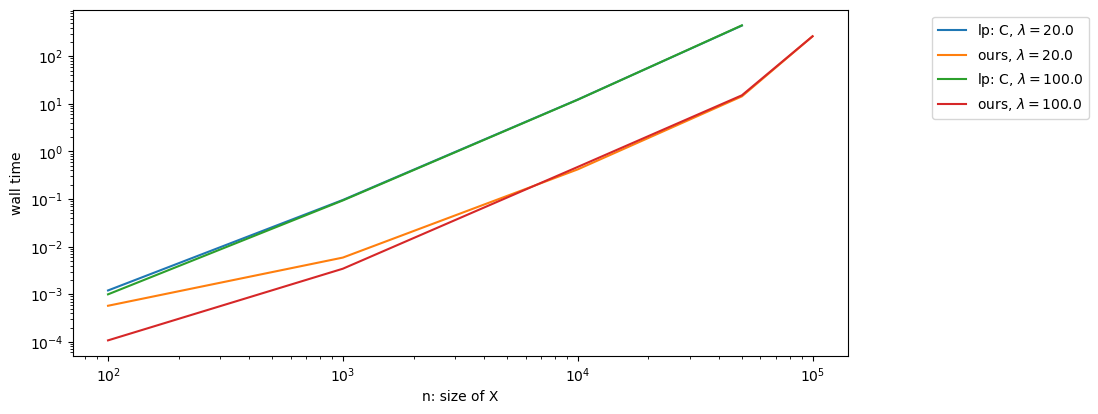

In [6]:

time_list=torch.load('experiment/reviewer/result/time_list.pt')
time_lp_list=time_list['lp']
time_new_list=time_list['new']

n_list=[int(1e2),int(1e3),int(1e4),5*int(1e4),int(1e5)]
step=500
k=10
fig = plt.figure(figsize=(6,5))
ax = plt.subplot(111)

for j in range(2):
    plt.loglog(n_list[:-1],time_lp_list[j][:-1],label='lp: C, $\lambda=$'+str(Lambda_list[j]))
    plt.loglog(n_list,time_new_list[j],label='ours, $\lambda=$'+str(Lambda_list[j]))
    #plt.loglog(n_list,time_new_C_list[j],label='ours_C, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
#plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.19),fancybox=True, shadow=True, ncol=3)
plt.legend(bbox_to_anchor=(1.1,1.0))
#plt.legend(loc='upper center',fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/reviewer/result/time_numba.pdf',format='pdf',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()

In [21]:
a=np.log(time_lp_list[j][:-1])/np.log(n_list[:-1])
print(a)
print(a[-1]-a[0])
b=np.log(time_new_list[j][:-1])/np.log(n_list[:-1])
print(b)
print(b[-1]-b[0])

[-1.08526799 -0.23243259  0.34421503  0.64422191]
1.7294899007230715
[-1.96667552 -0.84040739 -0.05366196  0.24912296]
2.215798485853375


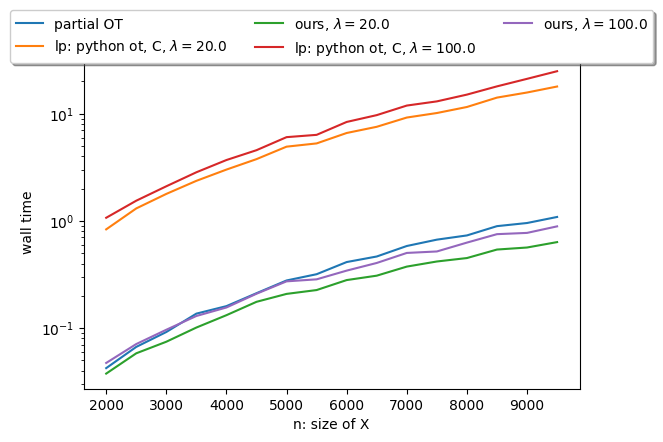

In [9]:
start_n=1500
end_n=10000
device='cpu'
step=500
k=10
n_list=range(start_n,end_n,step)[1:]
fig = plt.figure()
ax = plt.subplot(111)

plt.semilogy(n_list,time_pot_list[1:],label='partial OT')
for j in range(2):
#    plt.semilogy(n_list,time_v2_list[j][1:],label='ours,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_sinkhorn_list[j][1:],label='ours_a,$\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_lp_list[j][1:],label='lp: python ot, C, $\lambda=$'+str(Lambda_list[j]))
    plt.semilogy(n_list,time_new_list[j][1:],label='ours, $\lambda=$'+str(Lambda_list[j]))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
plt.legend(loc='upper center',bbox_to_anchor=(0.5, 1.16),
          fancybox=True, shadow=True, ncol=3)
plt.xlabel('n: size of X')
plt.ylabel("wall time")
plt.savefig('experiment/test/results/time_numba.png',format='png',dpi=800,bbox_inches='tight')
#plt.title('wall-clock time with accelaration')
plt.show()